# DCGAN 실습

In [0]:
import torch 
import torch.nn as nn # 
import torch.nn.functional as F #
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.autograd import Variable
from torch.utils import data

import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다.
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import pickle

## Quiz

In [0]:
#quiz 1 (torch.permute)

sample_array = np.random.randn(2000, 64, 64, 3)
sample = torch.from_numpy(np.array(sample_array))
# sample => (2000, 64, 64, 3).  
sample_1 = sample.permute(?, ?, ?, ?)    # 위 sample 을 (2000, 3, 64, 64)로 바꿔보세요.
print(sample_1.size())

torch.Size([2000, 3, 64, 64])


In [0]:
sample_2 = sample.permute(?, ?, ?, ?)    # 위 sample 을 (2000, 64, 3, 64)로 바꿔보세요.
print(sample_2.size())

torch.Size([2000, 64, 3, 64])


In [0]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.permute(0,2,1)
print(a1.shape)
a2 = a.permute(1,2,0)
print(a2.shape)

torch.Size([5, 100, 20])
torch.Size([20, 100, 5])


In [0]:
#quiz 2 (torch.view)

sample = torch.from_numpy(np.array(sample_array))
# sample => (2000, 64, 64, 3).  
sample_1 = sample.view(?, ?) #위 sample 을 (2000, 64*64*3)으로 바꿔보세요.
print(sample_1.size())

sample_2 = sample.view(?, ?) #위 sample 을 (2000*64, 64*3)로 바꿔보세요.
print(sample_2.size())

torch.Size([2000, 12288])
torch.Size([128000, 192])


In [0]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.view(2, 10, -1)
print(a1.shape)
a2 = a.view(-1,10, 200)
print(a2.shape)

torch.Size([2, 10, 500])
torch.Size([5, 10, 200])


## Convolution Layer

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [0]:
#quiz 3 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = Variable(torch.zeros(16, 3, 64, 64))
conv1 = nn.Conv2d(3, 512, 3, 1, 1)
conv2 = nn.Conv2d(?, ?, ?, ?, ?) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 128, 32, 32)

torch.Size([16, 128, 32, 32])


In [0]:
#quiz 4 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = Variable(torch.zeros(16, 3, 64, 64))
conv1 = nn.Conv2d(3, 64, 3, 1, 1)
conv2 = nn.Conv2d(?, ?, ?, ?, ?) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 512, 16, 16)

torch.Size([16, 512, 16, 16])


## Transpose Convolutional Layer

In [0]:
#quiz 5 (torch.nn.ConvTranspose2d)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, pad)
input1 = Variable(torch.zeros(16, 100, 1, 1))
conv1 = nn.ConvTranspose2d(100, 512, 4, 2, 1)
conv2 = nn.ConvTranspose2d(?, ?, ?, ?, ?) # quiz

out = conv1(input1)
print(out.size())
out = conv2(out)
print(out.size())
# print(out.size()) = (16, 256, 4, 4)

torch.Size([16, 512, 2, 2])
torch.Size([16, 256, 4, 4])


# MNIST DCGAN
## Data Loader 불러오기

In [0]:
def CIFAR10_DATA(root='./data/', train =True, transforms=None, download =True, batch_size=100, num_worker=1):
    print ("[+] Get the CIFAR-10 DATA")
    """
    torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다.
    """
    transform = T.Compose([T.ToTensor(), # 얻어낸 데이터를 pytorch가 계산 할 수 있는 Tensor 로 변환해 줍니다. 
                           T.Normalize(mean=(0.5, 0.5, 0.5), 
                                       std=(0.5, 0.5, 0.5))])
    
    cifar10_train = datasets.CIFAR10(root = root,  #root 는 데이터의 저장 위치 입니다. 
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
    cifar10_test = datasets.CIFAR10(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
                                transform = transform,
                                download = True)
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    * Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
    커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
    """
    trainDataLoader = data.DataLoader(dataset = cifar10_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = 1) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = cifar10_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return cifar10_train, cifar10_test, trainDataLoader, testDataLoader

In [0]:
trainDset, testDset, trainDataLoader, testDataLoader = CIFAR10_DATA(batch_size=50, num_worker=4)  # Data Loader 를 불러 옵니다. 

[+] Get the CIFAR-10 DATA
Files already downloaded and verified
Files already downloaded and verified
[+] Finished loading data & Preprocessing


## CIFAR10 Data 확인

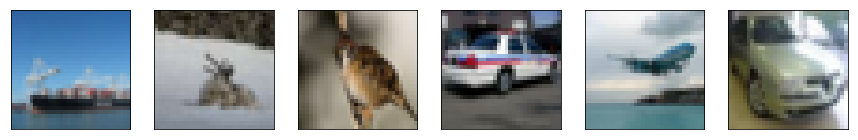

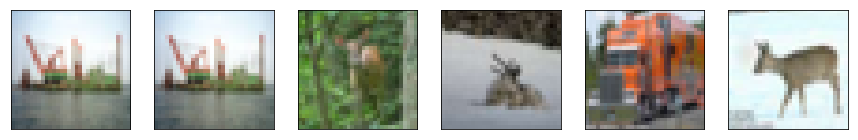

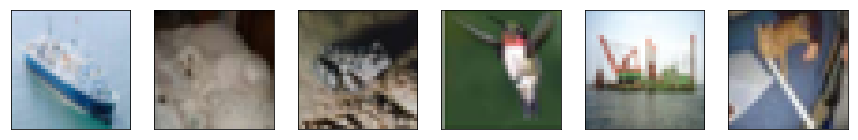

In [0]:
def show_images(image, n_row):
    for _ in range(n_row):  
        index=np.random.choice(50, 6)
        images =image.numpy()[index]
        plt.figure(figsize=(15,90))    
        for a in range(161, 167):    
            plt.subplot(a)
            plt.imshow(images[(a-161)].transpose(1,2,0))
            plt.xticks([])
            plt.yticks([])    
        plt.show()  

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
        
for i, (image,_) in enumerate(trainDataLoader):
    show_images(denorm(image.squeeze()), 3)
    break

## Discriminator, Generator

![image.png](attachment:image.png)

In [0]:
# conv function
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad)) # convolution 레이어입니다.
    if bn:
        layers.append(nn.BatchNorm2d(c_out))  # batch normalization 레이어를 추가해줍니다.
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    """Discriminator containing 3 convolutional layers."""
    def __init__(self, image_size=32, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, 64, 4, bn=False) # (?, 64, 16, 16)
        self.conv2 = conv(?, ?, ?) # (?, 128, 8, 8)
        self.conv3 = conv(?, ?, ?) # (?, 256, 4, 4)
        self.fc = conv(conv_dim*4, 1, int(image_size/8), 1, 0, False) # (?, 1, 1, 1)
        
    def forward(self, x):                         # If image_size is 32, output shape is as below.
        out = F.leaky_relu(self.conv1(x), 0.05)    
        out = F.leaky_relu(self.conv2(out), 0.05)  
        out = F.leaky_relu(self.conv3(out), 0.05)
        out = ?(self.fc(out).squeeze()) # Sigmoid 함수를 사용해야 합니다.
        return out

In [0]:
# deconv function
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    """Generator containing 3 deconvolutional layers."""
    def __init__(self, z_dim=256, image_size=32, conv_dim=64):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*4, int(image_size/8), 1, 0, bn=False) # (?, 256, 4, 4)
        self.deconv1 = deconv(256, 128, 4) # (?, 128, 8, 8)
        self.deconv2 = deconv(?, ?, ?) # (?, 64, 16, 16)
        self.deconv3 = deconv(?, ?, ?, bn=False) # (?, 3, 32, 32)
        
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)      # If image_size is 32, output shape is as below.
        out = self.fc(z)                            
        out = F.relu(self.deconv1(out))  
        out = F.relu(self.deconv2(out))
        out = ?(self.deconv3(out)) # 위 결과를 deconv3에 넣어서 나온 결과에 tanh를 (F.tanh) 통과시켜줍니다.             
        return out

In [0]:
# build model
G = Generator(z_dim=256, image_size=32, conv_dim=64)
D = Discriminator(image_size=32, conv_dim=64)

if torch.cuda.is_available():
    G.cuda()
    D.cuda()

In [0]:
def to_var(x):
    """Convert tensor to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def to_data(x):
    """Convert variable to tensor."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data

## Train Function

In [0]:
def train_network(D, G, trainloader):
    # Binary cross entropy loss and optimizer
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(D.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999
    g_optimizer = optim.Adam(G.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999
    
    for epoch in range(100):
        for i, (images, _) in enumerate(trainloader):
            # Build mini-batch dataset
            batch_size = images.size(0)
            images = to_var(images)

            # Create the labels which are later used as input for the BCE loss
            real_labels = to_var(torch.ones(batch_size))
            fake_labels = to_var(torch.zeros(batch_size))

            #============= Train the discriminator =============#
            # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
            # Second term of the loss is always zero since real_labels == 1
            outputs = D(images)
            d_loss_real = criterion(outputs, real_labels) # Discriminator가 real image를 1(Real)로 예측하도록 학습
            real_score = outputs

            # Compute BCELoss using fake images
            # First term of the loss is always zero since fake_labels == 0
            z = to_var(torch.randn(batch_size, 256))
            fake_images = G(z)
            outputs = D(fake_images)
            d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 fake image를 0(Fake)으로 예측하도록 학습
            fake_score = outputs

            # Backprop + Optimize
            d_loss = d_loss_real + d_loss_fake
            D.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            #=============== Train the generator ===============#
            # Compute loss with fake images
            z = to_var(torch.randn(batch_size, 256))
            fake_images = G(z)
            outputs = D(fake_images)

            # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
            # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
            g_loss = criterion(outputs, real_labels) # Generator에서 생성한 fake image가 Discriminator에서 1(Real)로 예측하도록 학습

            # Backprop + Optimize
            D.zero_grad()
            G.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if (i+1) % 300 == 0:
                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f' 
                      %(epoch, 100, i+1, len(trainloader), d_loss.item(), g_loss.item(), real_score.data.mean(), fake_score.data.mean()))
            if (i+1) % 300 == 0:
                fixed_z = to_var(torch.randn(batch_size, 256))
                G = test(G, fixed_z)

## Test Function

In [0]:
def test(G, fixed_z):
    G.eval()
    fake_images = G(fixed_z)  
    fake_images = (fake_images+1)/2
    images_to_show = fake_images.data.cpu().numpy().transpose((0,2,3,1))
    images_row = images_to_show[:6] 
  
    plt.figure(figsize=(15,75))
    for a in range(161, 167):    
        plt.subplot(a)
        plt.imshow(images_row[a-161])
        plt.xticks([])
        plt.yticks([])    
    plt.show() 
  
    G.train()
    return G

Epoch [0/200], Step[300/600], d_loss: 0.4765, g_loss: 1.8775, D(x): 0.75, D(G(z)): 0.14


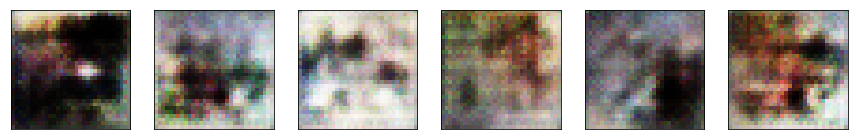

Epoch [0/200], Step[600/600], d_loss: 0.4253, g_loss: 1.9396, D(x): 0.85, D(G(z)): 0.21


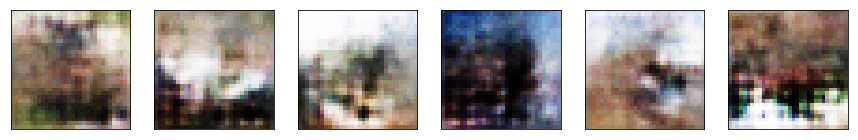

Epoch [0/200], Step[900/600], d_loss: 0.6473, g_loss: 4.1310, D(x): 0.90, D(G(z)): 0.38


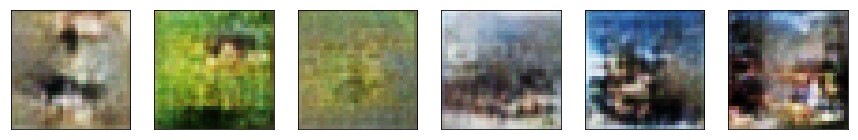

KeyboardInterrupt: 

In [0]:
train_network(D, G, trainDataLoader)

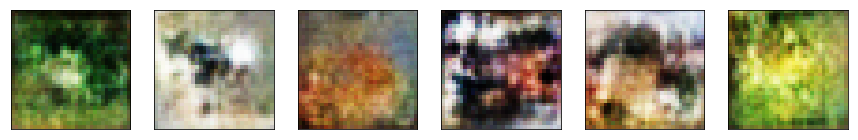

In [0]:
fixed_noise = Variable(torch.randn(6,256)).cuda()
_ = test(G, fixed_noise)

In [0]:
torch.save(G.state_dict(),'./model/dcgan_generator.pckl')
torch.save(D.state_dict(),'./model/dcgan_discriminator.pckl')